In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import csv
import pandas as pd
import json
import time
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import string 
import unicodedata as ud
from greek_stemmer import GreekStemmer
import pymongo
import numpy as np
import re
import networkx as nx
import indexer as ind

In [2]:
def create_graph_of_words(words_in_row:list)->nx.DiGraph:
    g = nx.DiGraph()
    #add unique words as nodes of the graph
    #g.add_nodes_from(set(words_in_row))
    for j,word in enumerate(words_in_row):
        #add word as a node if it doesnt exist
        if word not in g.nodes:
            g.add_node(word)    
        #generate list of indexes
        gen = (x for x in range(j+1,j+4) if x<len(words_in_row))
        for k in gen:
            #avoid self-loops
            if(word == words_in_row[k]):
                pass
            #if edge does not exist create it, else increase edge weight
            elif((word, words_in_row[k]) not in g.edges):
                g.add_edge(word, words_in_row[k])
                g[word][words_in_row[k]]['weight'] = 1
            else:
                g[word][words_in_row[k]]['weight'] += 1
    return g
def generate_graphs(total_documents:int, chunksize:int, database_collection):
    chunk = []
    counter = 0
    ticks = [x for x in range(0,total_documents,chunksize)]
    ticks.append(total_documents)
    graphs=[]
    with open('stopwords.txt', encoding='utf-8') as file:
        stopwords = [line.rstrip() for line in file]
    for j in range(len(ticks)-1):
        tokens = {}
        #read documents from MongoDB in chunks
        chunk = list(database_collection.find({ }, { "_id": 1, "speech": 1 })[ticks[j]:ticks[j+1]])
        print("Length of chunk: ", len(chunk))
        size_distribution = []
        #chunk = ["This is a sentance","This is another one"]
        #for each speech
        for i, row in enumerate(chunk):
            words_in_row = ind.preprocess_doc(row["speech"], stopwords)
            if(i==1):
                print(row["speech"])
                print(words_in_row)
            if(len(words_in_row)<20):
                graph = create_graph_of_words(words_in_row)
                graphs.append(graph)
                #extract keywords and insert to mongo
   
        
        print("CHUNK", counter, " FINISHED")
    
    return graphs

In [3]:
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
#mongo_client.drop_database("GreekParliamentProceedings")
client = mongo_client["GreekParliamentProceedings"]
index = client["InvertedIndex"]
database = client["Database"]

In [4]:
graphs = generate_graphs(1000,1000,database)

Length of chunk:  1000
 Παρακαλείται ο κύριος Γραμματέας να συνοδεύσει την Ιερά Σύνοδο εκτός της Αιθούσης της Βουλής.  . Παρακαλείται ο συνάδελφος Βουλευτής κ. Σαδίκ Αμέτ, που ανήκει στο Μωαμεθανικό Θρήσκευμα να προσέλθει και να δώσει τον οριζόμενο από το Σύνταγμα όρκο επί του Κορανίου.  : ~"Ορκίζομαι στο όνομα του Παντοδύναμου Θεού και του μόνου αυτού Προφήτη ο οποίος είναι ο Μωάμεθ να είμαι πιστός στην πατρίδα και το δημοκρατικό πολίτευμα, να υπακούω στο Σύνταγμα και τους νόμους και να εκπληρώνω ευσυνείδητα τα καθήκοντά μου".
['παρακαλειτα', 'γραμματ', 'συνοδευς', 'ιερ', 'συνοδ', 'αιθους', 'βουλ', 'παρακαλειτα', 'συναδελφ', 'βουλευτ', 'σαδικ', 'αμετ', 'ανηκ', 'μωαμεθαν', 'θρησκευμ', 'προσελθ', 'δως', 'οριζομεν', 'συνταγμ', 'ορκ', 'κοραν', 'ορκιζ', 'ονομ', 'παντοδυναμ', 'θε', 'προφητ', 'μωαμεθ', 'πιστ', 'πατριδ', 'δημοκρατ', 'πολιτευμ', 'υπακου', 'συνταγμ', 'νομ', 'εκπληρων', 'ευσυνειδητ', 'καθηκοντ']
CHUNK 0  FINISHED


In [1]:
text  = "επίσης Παρακαλείται ο κύριος Γραμματέας να συνοδεύσει την Ιερά Σύνοδο εκτός της Αιθούσης της Βουλής.  . Παρακαλείται ο συνάδελφος Βουλευτής κ. Σαδίκ Αμέτ, που ανήκει στο Μωαμεθανικό Θρήσκευμα να προσέλθει και να δώσει τον οριζόμενο από το Σύνταγμα όρκο επί του Κορανίου.  : ~Ορκίζομαι στο όνομα του Παντοδύναμου Θεού και του μόνου αυτού Προφήτη ο οποίος είναι ο Μωάμεθ να είμαι πιστός στην πατρίδα και το δημοκρατικό πολίτευμα, να υπακούω στο Σύνταγμα και τους νόμους και να εκπληρώνω ευσυνείδητα τα καθήκοντά μου"

In [2]:
import indexer as ind
with open('stopwords.txt', encoding='utf-8') as file:
    stopwords = [line.rstrip() for line in file]
res  = ind.preprocess_doc(text.lower(), stopwords)
print(res)

επισης παρακαλειται ο κυριος γραμματεας να συνοδευσει την ιερα συνοδο εκτος της αιθουσης της βουλης.  . παρακαλειται ο συναδελφος βουλευτης κ. σαδικ αμετ, που ανηκει στο μωαμεθανικο θρησκευμα να προσελθει και να δωσει τον οριζομενο απο το συνταγμα ορκο επι του κορανιου.  : ~ορκιζομαι στο ονομα του παντοδυναμου θεου και του μονου αυτου προφητη ο οποιος ειναι ο μωαμεθ να ειμαι πιστος στην πατριδα και το δημοκρατικο πολιτευμα, να υπακουω στο συνταγμα και τους νομους και να εκπληρωνω ευσυνειδητα τα καθηκοντα μου
['παρακαλειτα', 'γραμματ', 'συνοδευς', 'ιερ', 'συνοδ', 'αιθους', 'βουλ', 'παρακαλειτα', 'συναδελφ', 'βουλευτ', 'σαδικ', 'αμετ', 'ανηκ', 'μωαμεθαν', 'θρησκευμ', 'προσελθ', 'δως', 'οριζομεν', 'συνταγμ', 'ορκ', 'κοραν', 'ορκιζ', 'ονομ', 'παντοδυναμ', 'θε', 'προφητ', 'μωαμεθ', 'πιστ', 'πατριδ', 'δημοκρατ', 'πολιτευμ', 'υπακου', 'συνταγμ', 'νομ', 'εκπληρων', 'ευσυνειδητ', 'καθηκοντ']


In [7]:
max = 0
for i in range(len(graphs)):
    if(len(graphs[i].nodes)>max):
        max = len(graphs[i].nodes)
print(max)

19


In [8]:
from indexer import preprocess_doc
test = "επισης ο κυριος να"
t = preprocess_doc(test)
print(t)

[]


In [9]:
core = nx.k_core(graphs[271])
print(graphs[271])
print(core.nodes)
nx.in_degree_centrality(core)

DiGraph with 2 nodes and 1 edges
['εσεις', 'λ']


{'εσεις': 0.0, 'λ': 1.0}

In [10]:
#test, pls ignore
dataframe1 = list(collection.find({ }, { "_id": 1, "speech": 1 })[:100000])
for i, row in enumerate(dataframe1):
    #print(row["_id"])
    pass

NameError: name 'collection' is not defined

<Figure size 432x288 with 0 Axes>

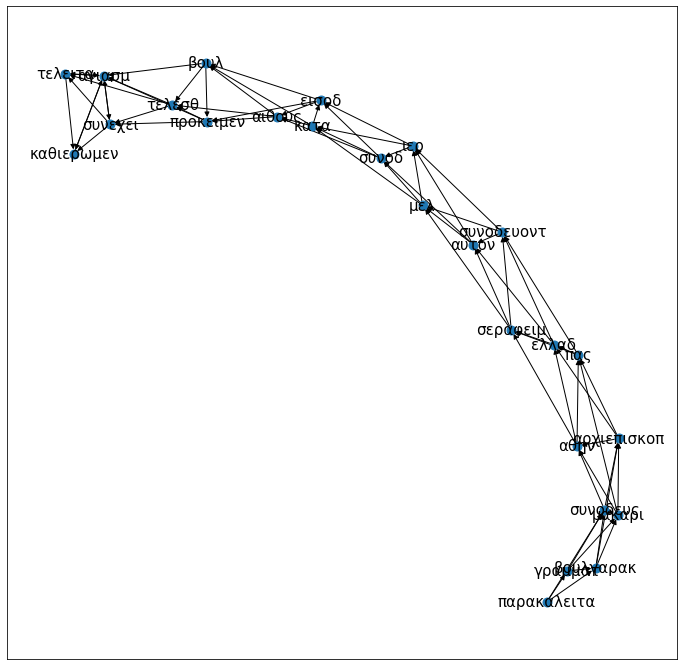

In [ ]:
#print(graphs[0].edges)
import matplotlib.pyplot as plt
 
plt.savefig('graph.png')
# larger figure size
#pos = nx.circular_layout(graphs[2])

plt.figure(3,figsize=(12,12)) 
nx.draw_networkx(graphs[0], with_labels=True,node_size=80,font_size=15)
plt.show()

In [ ]:
for i in range(len(graphs)):
    if(len(graphs[i].nodes)>400):
        res = nx.k_core(graphs[i])
        print(len(res.nodes))

303
89
77
54
41
21
78
30
14
27
42
56
40
35
30
74
54
94
43
52
46
40
46
11
88
41
83
41
43
30
18
17
11
51
23
42
15


## Networkx library test

In [ ]:
#networkx library
import networkx as nx
g = nx.Graph()
l = ['1','2','3']
#g.add_nodes_from(l)

for word in l:
    if(word not in list(g.nodes)):
        g.add_node(word)
for e in list(g.nodes):
    print(e)
    
g.add_edge('1','2')
g.add_edge('2','3')
if(('1','2') in g.edges):
    print(' in')
for e in list(g.edges):
    print(e)